In [1]:
import sionna as sn
import numpy as np
import tensorflow as tf

2023-07-04 13:51:56.343927: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-04 13:51:56.345505: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-04 13:51:56.374766: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-04 13:51:56.375168: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-04 13:51:56.940943: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
BATCH_SIZE = 200

In [5]:
class CellModel(tf.keras.Model):
    
    def __init__(self, scenario='umi', los=None, ground_users=False, num_bs_ant=8):

        super().__init__()

        self.NUM_BS_ANT = num_bs_ant
        self.NUM_UT = 8
        self.NUM_STREAMS_PER_TX = 2

        self.NUM_BITS_PER_SYMBOL = 4
        self.CODERATE = 0.5

        self.BS_HEIGHT = 15.0


        self.CARRIER_FREQUENCY = 1.9e9

        if ground_users:
            self.MAX_UT_HEIGHT = 2.0
            self.MIN_UT_HEIGHT = 1.0
        else:
            self.MAX_UT_HEIGHT = 300
            self.MIN_UT_HEIGHT = 20.0

        self.rx_tx_association = np.ones([1, self.NUM_UT])

        self.stream_management = sn.mimo.StreamManagement(
            rx_tx_association=self.rx_tx_association,
            num_streams_per_tx=self.NUM_STREAMS_PER_TX 
        )

        self.resource_grid = sn.ofdm.ResourceGrid(
            num_ofdm_symbols=11,
            fft_size=16,
            subcarrier_spacing=5e3,
            num_tx=self.NUM_UT,
            num_streams_per_tx=self.NUM_STREAMS_PER_TX,
            cyclic_prefix_length=6,
            pilot_pattern="kronecker",
            pilot_ofdm_symbol_indices=[1,9]
        )

        self.resource_grid_mapper = sn.ofdm.ResourceGridMapper(resource_grid=self.resource_grid)
        self.frequencies = sn.channel.subcarrier_frequencies(
            num_subcarriers=self.resource_grid.fft_size,
            subcarrier_spacing=self.resource_grid.subcarrier_spacing
        )

        NUM_CODED_BITS = int(self.resource_grid.num_data_symbols * self.NUM_BITS_PER_SYMBOL)
        self.NUM_INFO_BITS = int(NUM_CODED_BITS * self.CODERATE)

        self.binary_source = sn.utils.BinarySource()

        constellation = sn.mapping.Constellation('qam', self.NUM_BITS_PER_SYMBOL)
        self.mapper = sn.mapping.Mapper(constellation=constellation)
        self.demapper = sn.mapping.Demapper('app', constellation=constellation)

        self.encoder = sn.fec.ldpc.LDPC5GEncoder(self.NUM_INFO_BITS, NUM_CODED_BITS)
        self.decoder = sn.fec.ldpc.LDPC5GDecoder(encoder=self.encoder, hard_out=True)

        self.ls_est = sn.ofdm.LSChannelEstimator(resource_grid=self.resource_grid, interpolation_type='nn')

        self.lmmse_equ = sn.ofdm.LMMSEEqualizer(resource_grid=self.resource_grid, stream_management=self.stream_management)

        self.channel_freq = sn.channel.ApplyOFDMChannel(add_awgn=True)

        self.ut_array = sn.channel.tr38901.Antenna(
            polarization='dual',
            polarization_type='cross',
            antenna_pattern='omni',
            carrier_frequency=self.CARRIER_FREQUENCY
        )

        self.bs_array = sn.channel.tr38901.AntennaArray(
            num_rows=1,
            num_cols=self.NUM_BS_ANT,
            polarization='dual',
            polarization_type='cross',
            antenna_pattern='38.901',
            carrier_frequency=self.CARRIER_FREQUENCY
        )

        topology = sn.channel.gen_single_sector_topology(
            batch_size=BATCH_SIZE,
            indoor_probability=0,
            num_ut=self.NUM_UT,
            scenario=scenario,
            bs_height=self.BS_HEIGHT,
            max_ut_height=self.MAX_UT_HEIGHT,
            min_ut_height=self.MIN_UT_HEIGHT
        )

        if scenario == 'umi':
            self.channel_model = sn.channel.tr38901.UMi(
                carrier_frequency=self.CARRIER_FREQUENCY,
                o2i_model='low',
                ut_array=self.ut_array,
                bs_array=self.bs_array,
                direction='uplink',
                enable_pathloss=True,
                enable_shadow_fading=True
            )
        elif scenario == 'uma':
            self.channel_model = sn.channel.tr38901.UMa(
                carrier_frequency=self.CARRIER_FREQUENCY,
                o2i_model="low",
                ut_array=self.ut_array,
                bs_array=self.bs_array,
                direction='uplink',
                enable_pathloss=True,
                enable_shadow_fading=True
            )
    
        self.channel_model.set_topology(*topology, los=los)

    @tf.function
    def __call__(self, batch_size, ebno_db):

        no = sn.utils.ebnodb2no(
            coderate=self.CODERATE,
            num_bits_per_symbol=self.NUM_BITS_PER_SYMBOL,
            resource_grid=self.resource_grid,
            ebno_db=ebno_db
        ) 

        bits = self.binary_source([
            batch_size,
            self.NUM_UT,
            self.resource_grid.num_streams_per_tx,
            self.NUM_INFO_BITS
        ])
        coded_bits = self.encoder(bits)
        qam_symbols = self.mapper(coded_bits)
        ofdm_symbols = self.resource_grid_mapper(qam_symbols)

        a, tau = self.channel_model(
            num_time_samples=self.resource_grid.num_ofdm_symbols,
            sampling_frequency=1/self.resource_grid.ofdm_symbol_duration
        )
        h_freq = sn.channel.cir_to_ofdm_channel(
            frequencies=self.frequencies,
            a=a,
            tau=tau,
            normalize=True
        )
        received_symbols = self.channel_freq([ofdm_symbols, h_freq, no])
        estimation, err_var = self.ls_est([received_symbols, no])
        equalized_symbols, no_eff = self.lmmse_equ([ received_symbols, estimation, err_var, no])
        llr = self.demapper([equalized_symbols, no_eff])
        bits_hat = self.decoder(llr)

        return bits, bits_hat
                

In [4]:
ber_plots = sn.utils.PlotBER('UAV Simulation')

umi_uav = CellModel('umi', los=True)
uma_uav = CellModel('uma', los=True)
umi_ground = CellModel('umi', ground_users=True)
uma_ground = CellModel('uma', ground_users=True)
umi_ground_nlos = CellModel('umi', ground_users=True, los=False)
uma_ground_nlos = CellModel('uma', ground_users=True, los=False)

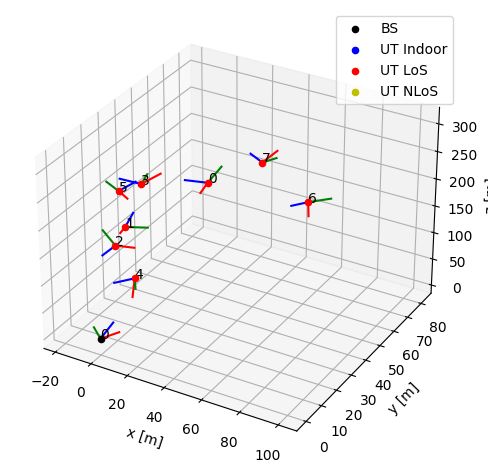

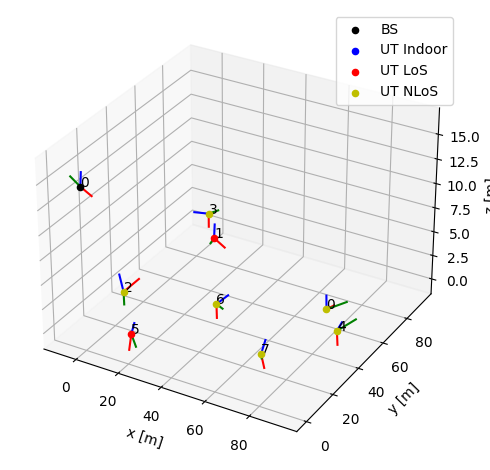

In [5]:
umi_uav.channel_model.show_topology();
umi_ground.channel_model.show_topology();

In [6]:
ber_plots.simulate(
  umi_uav,
  batch_size=BATCH_SIZE,
  ebno_dbs=np.linspace(-5,10,16),
  num_target_bit_errors=1000,
  legend='UAV com UMi',
  soft_estimates=False,
  max_mc_iter=1000,
  show_fig=False
)

2023-07-04 05:13:30.924447: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'batch_size' with dtype int32
	 [[{{node batch_size}}]]


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 2.6487e-01 | 9.4604e-01 |      732302 |     2764800 |         4541 |        4800 |        27.3 |reached target bit errors
     -4.0 | 2.4512e-01 | 9.0208e-01 |      677716 |     2764800 |         4330 |        4800 |        13.1 |reached target bit errors
     -3.0 | 2.2341e-01 | 8.5500e-01 |      617679 |     2764800 |         4104 |        4800 |        13.1 |reached target bit errors
     -2.0 | 2.0680e-01 | 8.1292e-01 |      571772 |     2764800 |         3902 |        4800 |        13.0 |reached target bit errors
     -1.0 | 1.8837e-01 | 7.5854e-01 |      520808 |     2764800 |      

(<tf.Tensor: shape=(16,), dtype=float64, numpy=
 array([0.26486617, 0.24512297, 0.2234082 , 0.20680411, 0.18837095,
        0.16715603, 0.15155273, 0.13036205, 0.11760815, 0.10639576,
        0.09336155, 0.08251953, 0.06989764, 0.06195747, 0.05377677,
        0.04736834])>,
 <tf.Tensor: shape=(16,), dtype=float64, numpy=
 array([0.94604167, 0.90208333, 0.855     , 0.81291667, 0.75854167,
        0.7       , 0.64229167, 0.56875   , 0.52458333, 0.476875  ,
        0.42354167, 0.38291667, 0.331875  , 0.29583333, 0.25916667,
        0.2325    ])>)

In [7]:
ber_plots.simulate(
  uma_uav,
  batch_size=BATCH_SIZE,
  ebno_dbs=np.linspace(-5,10,16),
  num_target_bit_errors=1000,
  legend='UAV com UMa',
  soft_estimates=False,
  max_mc_iter=1000,
  show_fig=False
)

2023-07-04 05:17:13.678234: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'batch_size' with dtype int32
	 [[{{node batch_size}}]]


EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 2.6694e-01 | 8.7375e-01 |      738038 |     2764800 |         4194 |        4800 |        19.8 |reached target bit errors
     -4.0 | 2.5001e-01 | 8.2937e-01 |      691231 |     2764800 |         3981 |        4800 |        13.2 |reached target bit errors
     -3.0 | 2.3708e-01 | 7.9354e-01 |      655468 |     2764800 |         3809 |        4800 |        12.9 |reached target bit errors
     -2.0 | 2.2624e-01 | 7.6667e-01 |      625519 |     2764800 |         3680 |        4800 |        12.9 |reached target bit errors
     -1.0 | 2.1682e-01 | 7.3854e-01 |      599475 |     2764800 |         3545 |        4800 |        13.0 |reached target bit errors
      0.0 | 2.0538e-01 | 7.0542e-01 |      567826 |     2764800 |         3

(<tf.Tensor: shape=(16,), dtype=float64, numpy=
 array([0.26694083, 0.25001121, 0.2370761 , 0.22624385, 0.216824  ,
        0.20537688, 0.19654044, 0.19075846, 0.18157552, 0.17348199,
        0.16594256, 0.16020978, 0.15248806, 0.14535446, 0.14028501,
        0.13277597])>,
 <tf.Tensor: shape=(16,), dtype=float64, numpy=
 array([0.87375   , 0.829375  , 0.79354167, 0.76666667, 0.73854167,
        0.70541667, 0.6825    , 0.66625   , 0.639375  , 0.61583333,
        0.59979167, 0.581875  , 0.56145833, 0.535625  , 0.52208333,
        0.49979167])>)

In [8]:
ber_plots.simulate(
    
  umi_ground,
  batch_size=BATCH_SIZE,
  ebno_dbs=np.linspace(-5,10,16),
  num_target_bit_errors=1000,
  legend='Solo com UMi',
  soft_estimates=False,
  max_mc_iter=1000,
  show_fig=False
)

2023-07-04 05:20:42.327245: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'batch_size' with dtype int32
	 [[{{node batch_size}}]]


EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 2.4188e-01 | 9.2333e-01 |      668757 |     2764800 |         4432 |        4800 |        18.7 |reached target bit errors
     -4.0 | 2.1523e-01 | 8.6104e-01 |      595059 |     2764800 |         4133 |        4800 |        12.1 |reached target bit errors
     -3.0 | 1.9213e-01 | 8.0083e-01 |      531193 |     2764800 |         3844 |        4800 |        12.0 |reached target bit errors
     -2.0 | 1.7277e-01 | 7.3708e-01 |      477669 |     2764800 |         3538 |        4800 |        12.0 |reached target bit errors
     -1.0 | 1.5075e-01 | 6.6333e-01 |      416799 |     2764800 |         3184 |        4800 |        12.0 |reached target bit errors
      0.0 | 1.3249e-01 | 6.0021e-01 |      366305 |     2764800 |         2

(<tf.Tensor: shape=(16,), dtype=float64, numpy=
 array([0.2418826 , 0.21522678, 0.1921271 , 0.17276801, 0.15075195,
        0.13248879, 0.1147772 , 0.09780852, 0.08719148, 0.07136393,
        0.06394821, 0.05481047, 0.04682473, 0.04179724, 0.03553458,
        0.03084599])>,
 <tf.Tensor: shape=(16,), dtype=float64, numpy=
 array([0.92333333, 0.86104167, 0.80083333, 0.73708333, 0.66333333,
        0.60020833, 0.52645833, 0.44833333, 0.40354167, 0.34854167,
        0.30979167, 0.2625    , 0.22520833, 0.2025    , 0.17916667,
        0.149375  ])>)

In [9]:
ber_plots.simulate(
  uma_ground,
  batch_size=BATCH_SIZE,
  ebno_dbs=np.linspace(-5,10,16),
  num_target_bit_errors=1000,
  legend='Solo com UMa',
  soft_estimates=False,
  max_mc_iter=1000,
  show_fig=False
)

2023-07-04 05:24:07.401186: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'batch_size' with dtype int32
	 [[{{node batch_size}}]]


EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 2.5337e-01 | 9.4354e-01 |      700512 |     2764800 |         4529 |        4800 |        19.6 |reached target bit errors
     -4.0 | 2.3217e-01 | 9.0521e-01 |      641901 |     2764800 |         4345 |        4800 |        13.1 |reached target bit errors
     -3.0 | 2.1341e-01 | 8.5979e-01 |      590038 |     2764800 |         4127 |        4800 |        12.8 |reached target bit errors
     -2.0 | 1.9223e-01 | 8.0417e-01 |      531489 |     2764800 |         3860 |        4800 |        12.9 |reached target bit errors
     -1.0 | 1.6811e-01 | 7.3167e-01 |      464782 |     2764800 |         3512 |        4800 |        12.8 |reached target bit errors
      0.0 | 1.5095e-01 | 6.8042e-01 |      417346 |     2764800 |         3

(<tf.Tensor: shape=(16,), dtype=float64, numpy=
 array([0.25336806, 0.23216905, 0.21341073, 0.19223416, 0.16810692,
        0.1509498 , 0.13853733, 0.12175637, 0.10787724, 0.09787797,
        0.08914569, 0.07934498, 0.07535952, 0.07057617, 0.0651038 ,
        0.06381836])>,
 <tf.Tensor: shape=(16,), dtype=float64, numpy=
 array([0.94354167, 0.90520833, 0.85979167, 0.80416667, 0.73166667,
        0.68041667, 0.62729167, 0.57      , 0.50958333, 0.469375  ,
        0.425625  , 0.37958333, 0.35625   , 0.331875  , 0.30583333,
        0.2925    ])>)

In [10]:
ber_plots.simulate(
  umi_ground_nlos,
  batch_size=BATCH_SIZE,
  ebno_dbs=np.linspace(-5,10,16),
  num_target_bit_errors=1000,
  legend='Solo com UMi e NLOS',
  soft_estimates=False,
  max_mc_iter=1000,
  show_fig=False
)

2023-07-04 05:27:40.420197: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'batch_size' with dtype int32
	 [[{{node batch_size}}]]


EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 2.5314e-01 | 9.7354e-01 |      699877 |     2764800 |         4673 |        4800 |        19.5 |reached target bit errors
     -4.0 | 2.2757e-01 | 9.3271e-01 |      629179 |     2764800 |         4477 |        4800 |        12.6 |reached target bit errors
     -3.0 | 2.0286e-01 | 8.8750e-01 |      560879 |     2764800 |         4260 |        4800 |        12.5 |reached target bit errors
     -2.0 | 1.7785e-01 | 8.2125e-01 |      491714 |     2764800 |         3942 |        4800 |        12.6 |reached target bit errors
     -1.0 | 1.5280e-01 | 7.4083e-01 |      422473 |     2764800 |         3556 |        4800 |        12.5 |reached target bit errors
      0.0 | 1.2558e-01 | 6.3479e-01 |      347190 |     2764800 |         3

(<tf.Tensor: shape=(16,), dtype=float64, numpy=
 array([0.25313838, 0.22756764, 0.20286422, 0.17784795, 0.15280418,
        0.12557509, 0.10442166, 0.08255064, 0.06268663, 0.05285843,
        0.04216942, 0.03234881, 0.02566081, 0.01943721, 0.01664786,
        0.01243634])>,
 <tf.Tensor: shape=(16,), dtype=float64, numpy=
 array([0.97354167, 0.93270833, 0.8875    , 0.82125   , 0.74083333,
        0.63479167, 0.545625  , 0.45645833, 0.35541667, 0.304375  ,
        0.24875   , 0.19604167, 0.15541667, 0.12145833, 0.10145833,
        0.075625  ])>)

In [11]:
ber_plots.simulate(
  uma_ground_nlos,
  batch_size=BATCH_SIZE,
  ebno_dbs=np.linspace(-5,10,16),
  num_target_bit_errors=1000,
  legend='Solo com UMa e NLOS',
  soft_estimates=False,
  max_mc_iter=1000,
  show_fig=False
)

2023-07-04 05:31:04.562334: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'batch_size' with dtype int32
	 [[{{node batch_size}}]]


EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 2.6290e-01 | 9.7021e-01 |      726866 |     2764800 |         4657 |        4800 |        21.9 |reached target bit errors
     -4.0 | 2.4296e-01 | 9.4146e-01 |      671735 |     2764800 |         4519 |        4800 |        12.3 |reached target bit errors
     -3.0 | 2.2270e-01 | 9.0812e-01 |      615734 |     2764800 |         4359 |        4800 |        12.2 |reached target bit errors
     -2.0 | 2.0185e-01 | 8.5542e-01 |      558069 |     2764800 |         4106 |        4800 |        12.3 |reached target bit errors
     -1.0 | 1.8201e-01 | 8.0896e-01 |      503229 |     2764800 |         3883 |        4800 |        12.2 |reached target bit errors
      0.0 | 1.6258e-01 | 7.4521e-01 |      449491 |     2764800 |         3

(<tf.Tensor: shape=(16,), dtype=float64, numpy=
 array([0.26290003, 0.24295971, 0.22270472, 0.20184787, 0.1820128 ,
        0.16257632, 0.1416985 , 0.12556315, 0.10987956, 0.09722729,
        0.08978877, 0.08217665, 0.08130389, 0.07143121, 0.06794488,
        0.07243092])>,
 <tf.Tensor: shape=(16,), dtype=float64, numpy=
 array([0.97020833, 0.94145833, 0.908125  , 0.85541667, 0.80895833,
        0.74520833, 0.66291667, 0.60458333, 0.53208333, 0.47708333,
        0.44416667, 0.40604167, 0.39208333, 0.34125   , 0.32625   ,
        0.33354167])>)

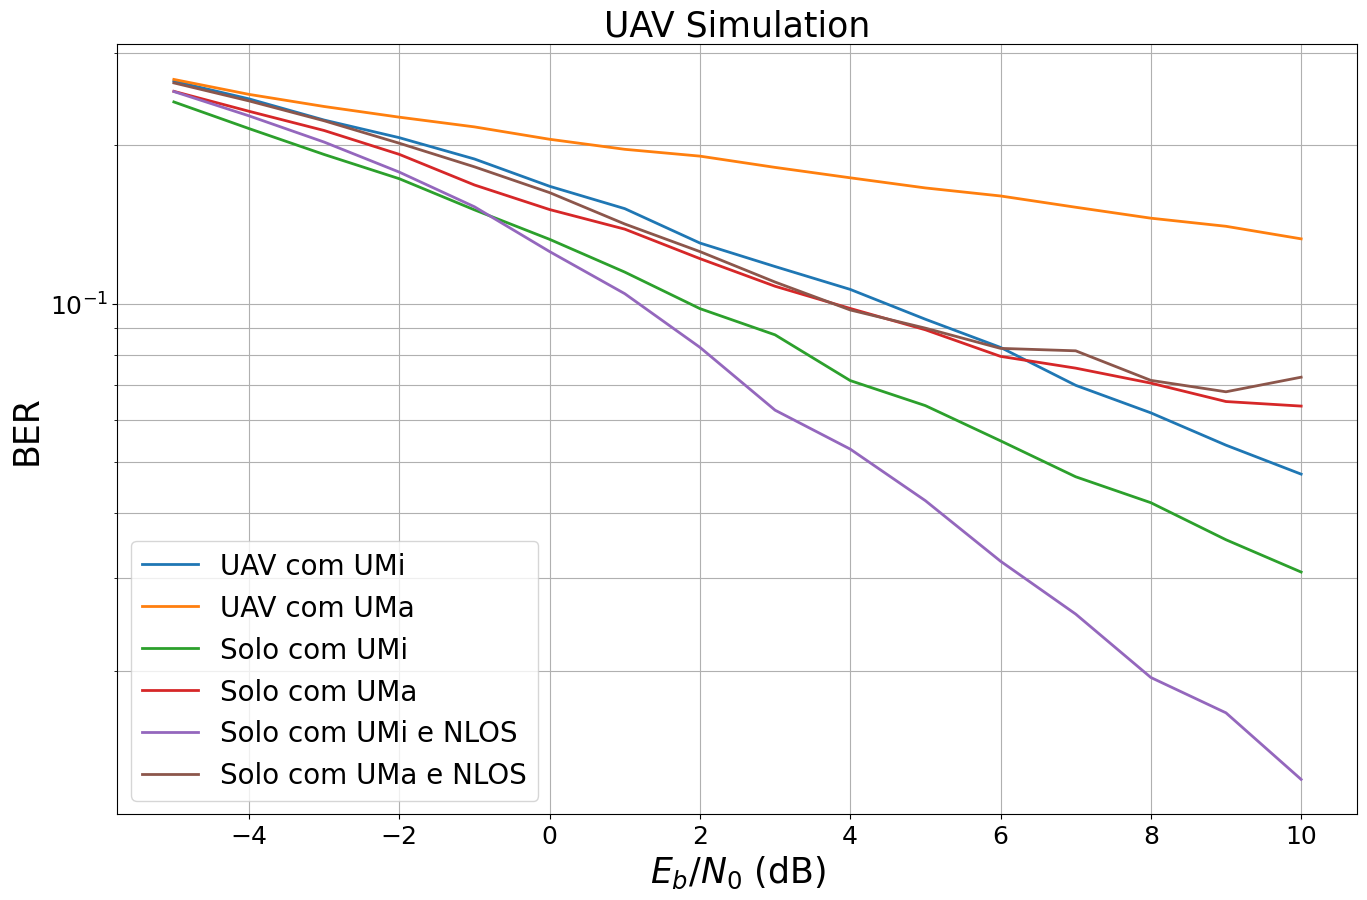

In [12]:
ber_plots();

In [6]:
ber_plots = sn.utils.PlotBER('Simulação UAV com 16 antenas')

umi_uav_16ant = CellModel('umi', los=True, num_bs_ant=16)
uma_uav_16ant = CellModel('uma', los=True, num_bs_ant=16)
umi_ground_16ant = CellModel('umi', los=False,  ground_users=True, num_bs_ant=16)
uma_ground_16ant = CellModel('uma', los=False,  ground_users=True, num_bs_ant=16)

In [7]:
ber_plots.simulate(
  umi_uav_16ant,
  batch_size=BATCH_SIZE,
  ebno_dbs=np.linspace(-5,10,16),
  num_target_bit_errors=1000,
  legend='UAV com UMi',
  soft_estimates=False,
  max_mc_iter=1000,
  show_fig=False
)

2023-07-04 13:56:26.051281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'batch_size' with dtype int32
	 [[{{node batch_size}}]]


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 9.0891e-02 | 4.3781e-01 |       83765 |      921600 |         1401 |        3200 |        16.9 |reached target bit errors
     -4.0 | 6.4752e-02 | 3.1344e-01 |       59675 |      921600 |         1003 |        3200 |         6.6 |reached target bit errors
     -3.0 | 4.5077e-02 | 2.2062e-01 |       41543 |      921600 |          706 |        3200 |         6.6 |reached target bit errors
     -2.0 | 3.7182e-02 | 1.7781e-01 |       34267 |      921600 |          569 |        3200 |         6.6 |reached target bit errors
     -1.0 | 2.6265e-02 | 1.2812e-01 |       24206 |      921600 |      

(<tf.Tensor: shape=(16,), dtype=float64, numpy=
 array([0.09089084, 0.06475152, 0.04507704, 0.03718207, 0.02626519,
        0.01862196, 0.01698242, 0.01190755, 0.00881402, 0.0077105 ,
        0.00660916, 0.00466037, 0.00310764, 0.00317274, 0.00222656,
        0.00227973])>,
 <tf.Tensor: shape=(16,), dtype=float64, numpy=
 array([0.4378125, 0.3134375, 0.220625 , 0.1778125, 0.128125 , 0.09     ,
        0.0775   , 0.055625 , 0.0403125, 0.0325   , 0.0290625, 0.0221875,
        0.014375 , 0.01375  , 0.0125   , 0.0109375])>)

In [8]:
ber_plots.simulate(
  uma_uav_16ant,
  batch_size=BATCH_SIZE,
  ebno_dbs=np.linspace(-5,10,16),
  num_target_bit_errors=1000,
  legend='UAV com UMa',
  soft_estimates=False,
  max_mc_iter=1000,
  show_fig=False
)

2023-07-04 13:58:25.637509: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'batch_size' with dtype int32
	 [[{{node batch_size}}]]


EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 1.1257e-01 | 4.3719e-01 |      103745 |      921600 |         1399 |        3200 |        12.6 |reached target bit errors
     -4.0 | 9.8099e-02 | 3.8219e-01 |       90408 |      921600 |         1223 |        3200 |         7.6 |reached target bit errors
     -3.0 | 8.5654e-02 | 3.4531e-01 |       78939 |      921600 |         1105 |        3200 |         7.0 |reached target bit errors
     -2.0 | 7.6579e-02 | 3.0719e-01 |       70575 |      921600 |          983 |        3200 |         7.4 |reached target bit errors
     -1.0 | 6.6859e-02 | 2.7250e-01 |       61617 |      921600 |          872 |        3200 |         7.2 |reached target bit errors
      0.0 | 6.1195e-02 | 2.4781e-01 |       56397 |      921600 |          

(<tf.Tensor: shape=(16,), dtype=float64, numpy=
 array([0.11257053, 0.09809896, 0.0856543 , 0.07657878, 0.06685872,
        0.06119466, 0.05412543, 0.0476964 , 0.04000868, 0.03640516,
        0.03202691, 0.02876736, 0.02475911, 0.02338325, 0.01936632,
        0.02135525])>,
 <tf.Tensor: shape=(16,), dtype=float64, numpy=
 array([0.4371875, 0.3821875, 0.3453125, 0.3071875, 0.2725   , 0.2478125,
        0.2246875, 0.1965625, 0.174375 , 0.15125  , 0.1315625, 0.1215625,
        0.104375 , 0.0965625, 0.0865625, 0.0928125])>)

In [9]:
ber_plots.simulate(
  umi_ground_16ant,
  batch_size=BATCH_SIZE,
  ebno_dbs=np.linspace(-5,10,16),
  num_target_bit_errors=1000,
  legend='Solo com UMi',
  soft_estimates=False,
  max_mc_iter=100,
  show_fig=False
)

2023-07-04 14:00:36.795327: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'batch_size' with dtype int32
	 [[{{node batch_size}}]]


EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 3.3894e-02 | 2.2844e-01 |       31237 |      921600 |          731 |        3200 |        13.7 |reached target bit errors
     -4.0 | 1.5500e-02 | 1.0781e-01 |       14285 |      921600 |          345 |        3200 |         8.4 |reached target bit errors
     -3.0 | 5.2159e-03 | 3.8125e-02 |        4807 |      921600 |          122 |        3200 |         8.4 |reached target bit errors
     -2.0 | 2.3177e-03 | 1.8750e-02 |        2136 |      921600 |           60 |        3200 |         8.2 |reached target bit errors
     -1.0 | 6.8142e-04 | 4.2188e-03 |        1256 |     1843200 |           27 |        6400 |        16.1 |reached target bit errors
      0.0 | 3.4966e-04 | 2.4219e-03 |        1289 |     3686400 |          

(<tf.Tensor: shape=(16,), dtype=float64, numpy=
 array([3.38943142e-02, 1.55002170e-02, 5.21592882e-03, 2.31770833e-03,
        6.81423611e-04, 3.49663628e-04, 1.11870660e-04, 1.04618779e-04,
        9.92838542e-05, 5.46332465e-05, 5.75086806e-05, 5.65140336e-05,
        6.48488562e-05, 5.85420800e-05, 1.29123264e-04, 7.06571691e-05])>,
 <tf.Tensor: shape=(16,), dtype=float64, numpy=
 array([0.2284375 , 0.1078125 , 0.038125  , 0.01875   , 0.00421875,
        0.00242187, 0.00075   , 0.00072917, 0.00057292, 0.00035937,
        0.00041118, 0.00041667, 0.00053309, 0.00066964, 0.00090278,
        0.00084559])>)

In [10]:
ber_plots.simulate(
  uma_ground_16ant,
  batch_size=BATCH_SIZE,
  ebno_dbs=np.linspace(-5,10,16),
  num_target_bit_errors=1000,
  legend='Solo com UMa',
  soft_estimates=False,
  max_mc_iter=100,
  show_fig=False
)

2023-07-04 14:23:07.640948: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'batch_size' with dtype int32
	 [[{{node batch_size}}]]


EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 8.6235e-02 | 4.7250e-01 |       79474 |      921600 |         1512 |        3200 |        13.3 |reached target bit errors
     -4.0 | 5.6038e-02 | 3.1219e-01 |       51645 |      921600 |          999 |        3200 |         7.2 |reached target bit errors
     -3.0 | 3.9545e-02 | 2.0750e-01 |       36445 |      921600 |          664 |        3200 |         7.2 |reached target bit errors
     -2.0 | 2.5951e-02 | 1.3812e-01 |       23916 |      921600 |          442 |        3200 |         7.1 |reached target bit errors
     -1.0 | 1.9346e-02 | 9.8750e-02 |       17829 |      921600 |          316 |        3200 |         7.2 |reached target bit errors
      0.0 | 1.4708e-02 | 7.3125e-02 |       13555 |      921600 |          

(<tf.Tensor: shape=(16,), dtype=float64, numpy=
 array([0.08623481, 0.05603841, 0.03954536, 0.02595052, 0.0193457 ,
        0.01470812, 0.01435004, 0.01195638, 0.01055013, 0.01271918,
        0.00787218, 0.00940538, 0.0093099 , 0.00902995, 0.00933919,
        0.011352  ])>,
 <tf.Tensor: shape=(16,), dtype=float64, numpy=
 array([0.4725   , 0.3121875, 0.2075   , 0.138125 , 0.09875  , 0.073125 ,
        0.065625 , 0.055625 , 0.04875  , 0.0571875, 0.040625 , 0.050625 ,
        0.054375 , 0.0559375, 0.0609375, 0.0771875])>)

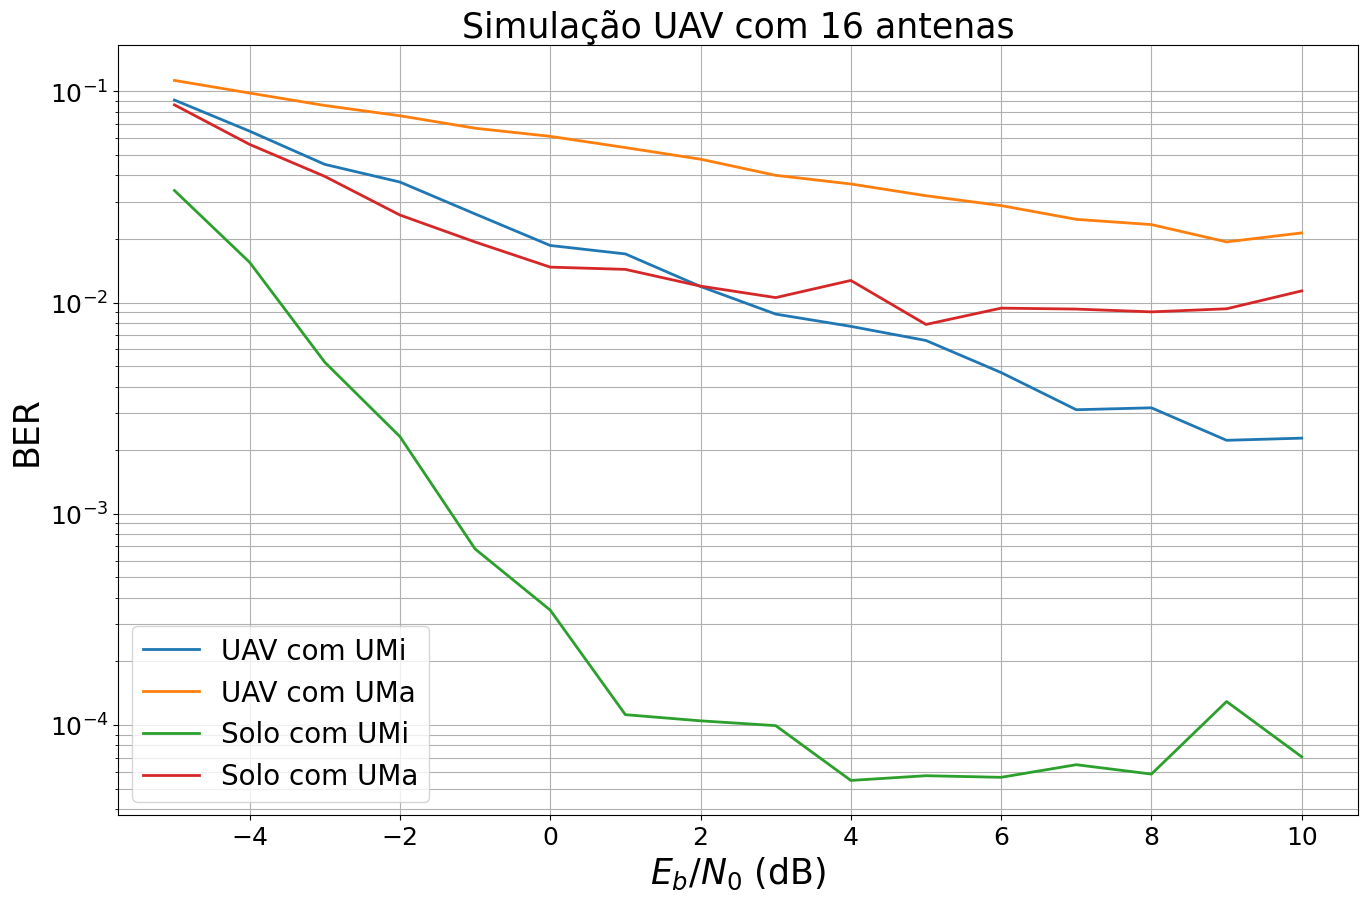

In [11]:
ber_plots()